In [ ]:
# Auther: Tzu-Han Hsu

# BSD 3-Clause License

# Copyright (c) 2022, Anywhere Door Lab (ADL) and Tzu-Han Hsu
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:

# 1. Redistributions of source code must retain the above copyright notice, this
#    list of conditions and the following disclaimer.

# 2. Redistributions in binary form must reproduce the above copyright notice,
#    this list of conditions and the following disclaimer in the documentation
#    and/or other materials provided with the distribution.

# 3. Neither the name of the copyright holder nor the names of its
#    contributors may be used to endorse or promote products derived from
#    this software without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [1]:
import torch
import torchvision 
import os
from torch.utils import data
from PIL import Image
import torchvision.datasets as dset
import numpy as np

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import matplotlib.pyplot as plt
import math
import pickle
from torchsummary import summary
from math import ceil
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#vital params



dataset_name="caltech101"
 
model_name="EfficientNetb4_stn1"
version = "b4"

base_model = [
    # expand_ratio, channels, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

phi_values = {
    # tuple of: (phi_value, resolution, drop_rate)
    "b0": (0, 224, 0.2),  # alpha, beta, gamma, depth = alpha ** phi
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

phi, res, drop_rate = phi_values[version]
#hyperparameters
batch_size=3
num_classes=-1
learning_rate=0.001
input_size=784
image_size=(res,res)


if dataset_name == "tsrd":
    num_classes=58
elif dataset_name == "cifar10":
    num_classes=10
elif dataset_name == "caltech101":
    num_classes=101
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Model: "+model_name +" with {} classes".format(num_classes)+
      " running on: "+dataset_name)


# load data through imagefolder
if dataset_name == "tsrd":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225]),

    ])

    train_dir = "../../dataset/data"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [5000, 998])
    train_set, test_set = data.random_split(train_set,[4000, 1000])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
elif dataset_name == "caltech101":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225]),

    ])

    train_dir = "../../dataset/caltech101"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [7477, 1200])
    train_set, test_set = data.random_split(train_set,[6277, 1200])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
    
    
elif dataset_name == "cifar10":
    
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5, 0.5, 0.5] , std = [0.5, 0.5, 0.5]),

    ])

    bigtrain_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=main_transforms)
    train_set, valid_set = data.random_split(bigtrain_set, [40000, 10000])
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=main_transforms)


    train_dataloader = torch.utils.data.DataLoader(train_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    val_dataloader = torch.utils.data.DataLoader(valid_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    test_dataloader = torch.utils.data.DataLoader(test_set,
                                                  batch_size=batch_size,
                                                  shuffle=False, num_workers=2)




print("Dataset size: Train: {}, Valid: {}, Test: {}"
      .format(len(train_set),len(valid_set),len(test_set)))

print(head_train_set.class_to_idx)
print(train_set[0][0].shape)
print("Datasets loaded and prepared")


Model: EfficientNetb4_stn1 with 101 classes running on: caltech101
Dataset size: Train: 6277, Valid: 1200, Test: 1200
{'Faces': 0, 'Faces_easy': 1, 'Leopards': 2, 'Motorbikes': 3, 'accordion': 4, 'airplanes': 5, 'anchor': 6, 'ant': 7, 'barrel': 8, 'bass': 9, 'beaver': 10, 'binocular': 11, 'bonsai': 12, 'brain': 13, 'brontosaurus': 14, 'buddha': 15, 'butterfly': 16, 'camera': 17, 'cannon': 18, 'car_side': 19, 'ceiling_fan': 20, 'cellphone': 21, 'chair': 22, 'chandelier': 23, 'cougar_body': 24, 'cougar_face': 25, 'crab': 26, 'crayfish': 27, 'crocodile': 28, 'crocodile_head': 29, 'cup': 30, 'dalmatian': 31, 'dollar_bill': 32, 'dolphin': 33, 'dragonfly': 34, 'electric_guitar': 35, 'elephant': 36, 'emu': 37, 'euphonium': 38, 'ewer': 39, 'ferry': 40, 'flamingo': 41, 'flamingo_head': 42, 'garfield': 43, 'gerenuk': 44, 'gramophone': 45, 'grand_piano': 46, 'hawksbill': 47, 'headphone': 48, 'hedgehog': 49, 'helicopter': 50, 'ibis': 51, 'inline_skate': 52, 'joshua_tree': 53, 'kangaroo': 54, 'ketc

In [2]:
class CNNBlock(nn.Module):
    def __init__(
            self, in_channels, out_channels, kernel_size, stride, padding, groups=1
    ):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU() # SiLU <-> Swish

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

class InvertedResidualBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            expand_ratio,
            reduction=4, # squeeze excitation
            survival_prob=0.8, # for stochastic depth
    ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels, hidden_dim, kernel_size=3, stride=1, padding=1,
            )

        self.conv = nn.Sequential(
            CNNBlock(
                hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim,
            ),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs

        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)


class EfficientNet(nn.Module):
    def __init__(self, version, num_classes):
        super(EfficientNet, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
        last_channels = ceil(1280 * width_factor)
        self.localization = nn.Sequential(
            #nn.Conv2d(3, 8, kernel_size=7),
            nn.Conv2d(3,8,kernel_size=3),
            nn.Conv2d(8,8,kernel_size=3),
            nn.Conv2d(8,8,kernel_size=3),
            
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            
            
            #nn.Conv2d(8, 10, kernel_size=5),
            nn.Conv2d(8,10, kernel_size = 3),
            nn.Conv2d(10,10,kernel_size = 3),
            
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10*91*91, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.features = self.create_features(width_factor, depth_factor, last_channels)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes),
        )
        


        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):

        xs = self.localization(x)
        xs = xs.view(-1, 10*91*91)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        
        
    def calculate_factors(self, version, alpha=1.2, beta=1.1):
        phi, res, drop_rate = phi_values[version]
        depth_factor = alpha ** phi
        width_factor = beta ** phi
        return width_factor, depth_factor, drop_rate

    def create_features(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [CNNBlock(3, channels, 3, stride=2, padding=1)]
        in_channels = channels

        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_channels = 4*ceil(int(channels*width_factor) / 4)
            layers_repeats = ceil(repeats * depth_factor)

            for layer in range(layers_repeats):
                features.append(
                    InvertedResidualBlock(
                        in_channels,
                        out_channels,
                        expand_ratio=expand_ratio,
                        stride = stride if layer == 0 else 1,
                        kernel_size=kernel_size,
                        padding=kernel_size//2, # if k=1:pad=0, k=3:pad=1, k=5:pad=2
                    )
                )
                in_channels = out_channels

        features.append(
            CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
        )

        return nn.Sequential(*features)

    def forward(self, x):
        self.stn(x)
        x = self.pool(self.features(x))
        
        return self.classifier(x.view(x.shape[0], -1))



In [3]:
model = EfficientNet(
    version=version,
    num_classes=num_classes,
).to(device)

model = model.to(device)

#pretesting model for shape
x=torch.randn(batch_size,3,res,res)
x=x.to(device)
print(x.shape)
print(model(x).shape)
print(summary(model, input_size=(3, res, res)))
print("model shape ready")

#initailise network


#loss and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)

print("model initialised")

torch.Size([3, 3, 380, 380])


C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


torch.Size([3, 101])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 378, 378]             224
            Conv2d-2          [-1, 8, 376, 376]             584
            Conv2d-3          [-1, 8, 374, 374]             584
         MaxPool2d-4          [-1, 8, 187, 187]               0
              ReLU-5          [-1, 8, 187, 187]               0
            Conv2d-6         [-1, 10, 185, 185]             730
            Conv2d-7         [-1, 10, 183, 183]             910
         MaxPool2d-8           [-1, 10, 91, 91]               0
              ReLU-9           [-1, 10, 91, 91]               0
           Linear-10                   [-1, 32]       2,649,952
             ReLU-11                   [-1, 32]               0
           Linear-12                    [-1, 6]             198
           Conv2d-13         [-1, 42, 190, 190]           1,134
      BatchNorm2d-

In [4]:
# This is the testing part
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(model)

def test(model, test_loader, istest= False, doprint=True):
    model.eval()
    test_loss = 0
    correct = 0
    TP=0
    TN=0
    FN=0
    FP=0
    test_loss = 0.0
    
    with torch.no_grad(): # disable gradient calculation for efficiency
        for data, target in tqdm(test_loader):
            # Prediction
            data=data.to(device=device)
            target=target.to(device=device)
            optimizer.zero_grad()
            
            output = model(data)
            loss=criterion(output,target)
            
            # Compute loss & accuracy
            test_loss+=loss.item()*data.size(0)

            
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in this batch are correct
            
            #print("pred={} , target={} , judge={}".format(pred.item(),target.item(),pred.eq(target.view_as(pred)).sum().item()))

            
    #test_loss /= len(test_loader.dataset)

        
    # Log testing info
    if istest and doprint:
        
        print('Loss: {}   Accuracy: {}/{} ({:.3f}%)'.format(test_loss,
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
        print("Total parameters: {}".format(get_n_params(model)))
    elif doprint:
        print('Accuracy: {}/{} ({:.3f}%)'.format(
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
    return 100.000 * correct / len(test_loader.dataset)
        

print("test defined")

def testshouldearlystop(acclist,minepoch,epochwindow,accwindow):
    runlen=len(acclist)
    if(runlen<minepoch):
        return False
    elif(acclist[-1]>acclist[-2]):
        return False
    
    watchwindow=acclist[-epochwindow:]
    shouldjump=True
    sum=0
    for i in watchwindow:
        sum+=i
    avg = sum/epochwindow
    for i in watchwindow:
        if abs(i-avg)>(accwindow):
            shouldjump=False
    return shouldjump
print("early stop defined")

test defined
early stop defined


In [5]:
now=datetime.now()
dt_string = now.strftime("%Y%m%d%H%M%S")

tensorboard_string="runs/"+model_name+dt_string
grandstore_string="grandstore/"+dataset_name+"_"+model_name+dt_string+".pkl"
print("tensorboard_string:")
print(tensorboard_string)
print("grandstore_string:")
print(grandstore_string)


writer = SummaryWriter(tensorboard_string)


tensorboard_string:
runs/EfficientNetb4_stn120220102014549
grandstore_string:
grandstore/caltech101_EfficientNetb4_stn120220102014549.pkl


In [6]:
#This is the training part

# Grand_store={
#     'total_epoch_run':-1
#     'topmodels':-1
#     'lastmodel':-1
#     'acclog':[]
#     'maxacc':-1
#     'minacc':101
# }
# train_epoch={
#     "numofepoch":-1
#     "accuracy":-1
#     "model_state":model.state_dict(),
#     "optim_state":optimizer.state_dict(),
#     "totaltrain_loss":totaltrain_loss,
#     "totalvalid_loss":totalvalid_loss
# }

def training(max_epoch=120, top_accuracy_track=3, grandstore={},
             minepoch=30,epochwindow=10,accwindow=0.35):

    grandstore['total_epoch_run']=0
    grandstore['topmodels']=[]
    grandstore['acclog']=[]
    grandstore['maxacc']=-1
    grandstore['minacc']=101
    
    for epoch in range(0,max_epoch):
        
        grandstore['total_epoch_run']=epoch+1
        
        train_epoch={
        "numofepoch":grandstore['total_epoch_run']
        }
    
        train_loss=0.0
        valid_loss=0.0
        print("Running epoch: {}".format(epoch+1))

        model.train()
        totaltrain_loss=0
        
        #this is the training part
        for data,target in tqdm(train_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            totaltrain_loss += train_loss

        #this is the validation part
        model.eval()
        totalvalid_loss=0;
        correct = 0
        for data,target in tqdm(val_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output=model(data)
            loss=criterion(output,target)
            valid_loss=loss.item()*data.size(0)
            #train_loss = train_loss/len(train_dataloader.dataset)
            #valid_loss = valid_loss/len(val_dataloader.dataset)
            totalvalid_loss+=valid_loss
            
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in t
        

        training_accuracy=100. * correct / len(val_dataloader.dataset)
        train_epoch["accuracy"]=training_accuracy
        train_epoch["totaltrain_loss"]=totaltrain_loss
        train_epoch["totalvalid_loss"]=totalvalid_loss
        
        #writings to the GrandStore
        
        grandstore['acclog'].append(training_accuracy)
        
        if training_accuracy < grandstore['minacc']:
            grandstore['minacc'] = training_accuracy
            
        if training_accuracy > grandstore['maxacc']:
            grandstore['maxacc'] = training_accuracy
        

        if epoch < top_accuracy_track:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'].append((training_accuracy,thisepochtestresult,epoch+1,train_epoch))
            #if error print this
            grandstore['topmodels'].sort()

        elif training_accuracy > grandstore['topmodels'][0][0]:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'][0]=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            #if error print this
            grandstore['topmodels'].sort()

        if epoch == (max_epoch-1):
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
                     
        writer.add_scalar('Training Loss',totaltrain_loss,global_step = epoch)
        writer.add_scalar('Valid Loss',totalvalid_loss,global_step = epoch)
        writer.add_scalar('Accuracy',training_accuracy,global_step = epoch)
        
        print('Accuracy: {:.3f}'.format(training_accuracy))
        print('Training Loss: {:.4f} \tValidation Loss: {:.4f}\n'.format(totaltrain_loss, totalvalid_loss))
        
        #early stopping criteria
        if(testshouldearlystop(acclist=grandstore['acclog'],
                               minepoch = minepoch,
                               epochwindow = epochwindow,
                               accwindow = accwindow)):
            print("early stop occured!!")
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            return grandstore
    
    return grandstore
        


In [7]:
TOP_ACCURACY_TRACK = 12
# max_epoch=120, top_accuracy_track=3, grandstore={},
# minepoch=30,epochwindow=10,accwindow=0.35

Grandstore=training(max_epoch=350,
                    minepoch=200,
                    top_accuracy_track=TOP_ACCURACY_TRACK,
                    epochwindow=10,
                    accwindow=0.25                 
                   )

Running epoch: 1


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 9.167
Training Loss: 28581623.4402 	Validation Loss: 5668.1771

Running epoch: 2


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 8.167
Training Loss: 27915406.5717 	Validation Loss: 5061.8488

Running epoch: 3


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 9.417
Training Loss: 27675088.8589 	Validation Loss: 5075.4795

Running epoch: 4


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 10.917
Training Loss: 27804873.1367 	Validation Loss: 5027.9395

Running epoch: 5


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 13.583
Training Loss: 27615119.0720 	Validation Loss: 4942.2241

Running epoch: 6


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 20.417
Training Loss: 26837093.3635 	Validation Loss: 4463.4842

Running epoch: 7


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 22.917
Training Loss: 25002081.4426 	Validation Loss: 4244.1800

Running epoch: 8


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 28.250
Training Loss: 23800024.1349 	Validation Loss: 4008.4811

Running epoch: 9


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 29.750
Training Loss: 22882460.7856 	Validation Loss: 3857.6501

Running epoch: 10


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 35.583
Training Loss: 21755072.6875 	Validation Loss: 3654.9727

Running epoch: 11


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 37.417
Training Loss: 20605652.9897 	Validation Loss: 3534.4396

Running epoch: 12


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 40.750
Training Loss: 19222064.2699 	Validation Loss: 3222.0660

Running epoch: 13


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 42.083
Training Loss: 18343969.4743 	Validation Loss: 3175.2978

Running epoch: 14


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 45.667
Training Loss: 17435366.2180 	Validation Loss: 2959.8612

Running epoch: 15


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 46.333
Training Loss: 16587654.5747 	Validation Loss: 2952.7318

Running epoch: 16


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 46.083
Training Loss: 15789023.6203 	Validation Loss: 2899.2504

Running epoch: 17


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 50.083
Training Loss: 14696708.2893 	Validation Loss: 2566.5284

Running epoch: 18


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 50.500
Training Loss: 14025283.8156 	Validation Loss: 2587.1309

Running epoch: 19


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 53.250
Training Loss: 12982045.1785 	Validation Loss: 2374.2401

Running epoch: 20


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 54.250
Training Loss: 12569157.0820 	Validation Loss: 2362.0282

Running epoch: 21


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 54.833
Training Loss: 11820768.9864 	Validation Loss: 2325.7067

Running epoch: 22


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 55.917
Training Loss: 10932529.2011 	Validation Loss: 2166.0761

Running epoch: 23


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 58.167
Training Loss: 10163412.3046 	Validation Loss: 2144.1247

Running epoch: 24


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 57.167
Training Loss: 9464311.9941 	Validation Loss: 2188.2519

Running epoch: 25


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 60.417
Training Loss: 8811927.0411 	Validation Loss: 2061.8609

Running epoch: 26


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 61.000
Training Loss: 8083723.8837 	Validation Loss: 1969.7278

Running epoch: 27


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 62.417
Training Loss: 7569060.5023 	Validation Loss: 1966.9010

Running epoch: 28


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 62.917
Training Loss: 6793325.5056 	Validation Loss: 2009.0477

Running epoch: 29


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 62.000
Training Loss: 5972160.5504 	Validation Loss: 1999.8216

Running epoch: 30


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 63.417
Training Loss: 5740963.8722 	Validation Loss: 1987.7768

Running epoch: 31


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 63.833
Training Loss: 5188665.2442 	Validation Loss: 2015.5354

Running epoch: 32


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.833
Training Loss: 4574683.4524 	Validation Loss: 2037.3655

Running epoch: 33


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 63.833
Training Loss: 3937240.0673 	Validation Loss: 2119.9162

Running epoch: 34


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 63.250
Training Loss: 3630642.7560 	Validation Loss: 2124.7124

Running epoch: 35


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.833
Training Loss: 3104510.0906 	Validation Loss: 2097.5202

Running epoch: 36


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 63.750
Training Loss: 3128216.5599 	Validation Loss: 2171.1439

Running epoch: 37


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.750
Training Loss: 2692040.7252 	Validation Loss: 2096.8927

Running epoch: 38


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.500
Training Loss: 2388100.7362 	Validation Loss: 2214.5490

Running epoch: 39


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.500
Training Loss: 2276435.3985 	Validation Loss: 2077.6797

Running epoch: 40


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.667
Training Loss: 2087114.3977 	Validation Loss: 2235.1052

Running epoch: 41


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.083
Training Loss: 2054415.3245 	Validation Loss: 2387.0115

Running epoch: 42


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.750
Training Loss: 1958123.2401 	Validation Loss: 2386.0724

Running epoch: 43


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.250
Training Loss: 1639696.9799 	Validation Loss: 2316.4398

Running epoch: 44


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.083
Training Loss: 1668840.0389 	Validation Loss: 2282.3715

Running epoch: 45


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.333
Training Loss: 1507512.4850 	Validation Loss: 2272.4565

Running epoch: 46


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.500
Training Loss: 1488845.4523 	Validation Loss: 2334.7721

Running epoch: 47


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.167
Training Loss: 1293441.1177 	Validation Loss: 2395.6013

Running epoch: 48


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.417
Training Loss: 1321309.1773 	Validation Loss: 2457.6895

Running epoch: 49


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.833
Training Loss: 1317269.6322 	Validation Loss: 2598.3102

Running epoch: 50


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.750
Training Loss: 1224141.2454 	Validation Loss: 2313.2510

Running epoch: 51


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.750
Training Loss: 1176910.6716 	Validation Loss: 2355.8271

Running epoch: 52


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.667
Training Loss: 1097013.9405 	Validation Loss: 2461.2521

Running epoch: 53


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.000
Training Loss: 1033851.4491 	Validation Loss: 2387.0624

Running epoch: 54


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.000
Training Loss: 1032218.4941 	Validation Loss: 2400.7776

Running epoch: 55


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.500
Training Loss: 1014313.6800 	Validation Loss: 2349.0080

Running epoch: 56


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.500
Training Loss: 936816.2910 	Validation Loss: 2514.3295

Running epoch: 57


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.000
Training Loss: 1012914.0675 	Validation Loss: 2371.0242

Running epoch: 58


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.750
Training Loss: 828180.1428 	Validation Loss: 2454.4188

Running epoch: 59


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.417
Training Loss: 985796.6476 	Validation Loss: 2414.8511

Running epoch: 60


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.250
Training Loss: 847060.3766 	Validation Loss: 2542.1507

Running epoch: 61


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.583
Training Loss: 795183.1505 	Validation Loss: 2441.8162

Running epoch: 62


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.083
Training Loss: 833855.6481 	Validation Loss: 2393.6179

Running epoch: 63


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.083
Training Loss: 749371.4232 	Validation Loss: 2381.3481

Running epoch: 64


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.833
Training Loss: 772315.5150 	Validation Loss: 2437.2558

Running epoch: 65


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.833
Training Loss: 678702.2195 	Validation Loss: 2468.5297

Running epoch: 66


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.583
Training Loss: 789528.3127 	Validation Loss: 2580.8131

Running epoch: 67


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 64.250
Training Loss: 745244.2198 	Validation Loss: 2976.9764

Running epoch: 68


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 66.750
Training Loss: 755200.1203 	Validation Loss: 2673.6202

Running epoch: 69


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.250
Training Loss: 643984.4569 	Validation Loss: 2514.2322

Running epoch: 70


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.833
Training Loss: 674748.8913 	Validation Loss: 2493.6614

Running epoch: 71


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.000
Training Loss: 707922.9838 	Validation Loss: 2471.0836

Running epoch: 72


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.500
Training Loss: 663307.8851 	Validation Loss: 2514.6508

Running epoch: 73


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.000
Training Loss: 620919.5129 	Validation Loss: 2441.2031

Running epoch: 74


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 67.000
Training Loss: 612752.7832 	Validation Loss: 2539.0341

Running epoch: 75


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.000
Training Loss: 612329.0271 	Validation Loss: 2544.9666

Running epoch: 76


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.250
Training Loss: 690709.0998 	Validation Loss: 2683.1320

Running epoch: 77


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.500
Training Loss: 662490.8148 	Validation Loss: 2564.8801

Running epoch: 78


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 67.333
Training Loss: 646152.8878 	Validation Loss: 2397.9703

Running epoch: 79


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 66.917
Training Loss: 526901.6351 	Validation Loss: 2510.2417

Running epoch: 80


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.083
Training Loss: 571223.1520 	Validation Loss: 2531.8319

Running epoch: 81


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.083
Training Loss: 590698.9522 	Validation Loss: 2554.8914

Running epoch: 82


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.333
Training Loss: 503516.6966 	Validation Loss: 2692.3663

Running epoch: 83


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 67.917
Training Loss: 544144.6609 	Validation Loss: 2667.9942

Running epoch: 84


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.083
Training Loss: 467188.3905 	Validation Loss: 2718.2509

Running epoch: 85


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 67.917
Training Loss: 576320.5659 	Validation Loss: 2626.6039

Running epoch: 86


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.500
Training Loss: 560653.4265 	Validation Loss: 2556.5359

Running epoch: 87


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.000
Training Loss: 543437.9947 	Validation Loss: 2639.4316

Running epoch: 88


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.833
Training Loss: 425459.7824 	Validation Loss: 2548.2484

Running epoch: 89


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.583
Training Loss: 500015.4487 	Validation Loss: 2599.6478

Running epoch: 90


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.917
Training Loss: 477198.7795 	Validation Loss: 2652.5428

Running epoch: 91


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.250
Training Loss: 549347.7205 	Validation Loss: 2517.6949

Running epoch: 92


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.417
Training Loss: 469431.5327 	Validation Loss: 2565.5395

Running epoch: 93


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.250
Training Loss: 475395.7098 	Validation Loss: 2454.7815

Running epoch: 94


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.083
Training Loss: 521768.3188 	Validation Loss: 2673.2188

Running epoch: 95


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 68.500
Training Loss: 432773.8607 	Validation Loss: 2813.3253

Running epoch: 96


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 69.000
Training Loss: 463242.6004 	Validation Loss: 2619.3057

Running epoch: 97


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.167
Training Loss: 570117.5017 	Validation Loss: 2581.8899

Running epoch: 98


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.417
Training Loss: 463499.3927 	Validation Loss: 2620.8308

Running epoch: 99


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.750
Training Loss: 420784.7234 	Validation Loss: 2414.0978

Running epoch: 100


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.333
Training Loss: 460146.9866 	Validation Loss: 2578.8034

Running epoch: 101


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.417
Training Loss: 486253.9793 	Validation Loss: 2544.8766

Running epoch: 102


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 68.583
Training Loss: 404860.0229 	Validation Loss: 2595.1727

Running epoch: 103


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.000
Training Loss: 371673.2257 	Validation Loss: 2512.4686

Running epoch: 104


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.250
Training Loss: 409303.5494 	Validation Loss: 2559.8672

Running epoch: 105


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.667
Training Loss: 479411.5143 	Validation Loss: 2615.1387

Running epoch: 106


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.000
Training Loss: 449033.7634 	Validation Loss: 2640.4717

Running epoch: 107


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 69.583
Training Loss: 331460.2452 	Validation Loss: 2621.4160

Running epoch: 108


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.667
Training Loss: 430185.7378 	Validation Loss: 2627.6011

Running epoch: 109


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 67.833
Training Loss: 409596.8429 	Validation Loss: 2694.2120

Running epoch: 110


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 68.917
Training Loss: 453033.8372 	Validation Loss: 2664.3328

Running epoch: 111


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 69.833
Training Loss: 294218.4221 	Validation Loss: 2742.3763

Running epoch: 112


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 67.333
Training Loss: 407471.0894 	Validation Loss: 2880.3302

Running epoch: 113


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 66.917
Training Loss: 335381.5544 	Validation Loss: 3118.9039

Running epoch: 114


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 69.250
Training Loss: 429866.8707 	Validation Loss: 2817.3832

Running epoch: 115


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.167
Training Loss: 380673.9349 	Validation Loss: 2841.1419

Running epoch: 116


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.333
Training Loss: 359502.8953 	Validation Loss: 2657.2711

Running epoch: 117


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 69.667
Training Loss: 266368.4973 	Validation Loss: 2802.2627

Running epoch: 118


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 68.917
Training Loss: 458248.7358 	Validation Loss: 2796.8258

Running epoch: 119


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 68.250
Training Loss: 290270.5521 	Validation Loss: 2901.2403

Running epoch: 120


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 68.417
Training Loss: 385148.5623 	Validation Loss: 2833.6584

Running epoch: 121


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.000
Training Loss: 312779.4124 	Validation Loss: 2695.1398

Running epoch: 122


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.917
Training Loss: 379689.3028 	Validation Loss: 2596.3550

Running epoch: 123


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.833
Training Loss: 333327.6771 	Validation Loss: 2519.3193

Running epoch: 124


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.167
Training Loss: 362689.0497 	Validation Loss: 2537.4369

Running epoch: 125


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 68.333
Training Loss: 344412.6686 	Validation Loss: 2651.1861

Running epoch: 126


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 69.750
Training Loss: 354008.9414 	Validation Loss: 2803.4471

Running epoch: 127


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.167
Training Loss: 363916.9572 	Validation Loss: 2729.7212

Running epoch: 128


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.750
Training Loss: 374026.2380 	Validation Loss: 2572.5289

Running epoch: 129


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.750
Training Loss: 330609.2904 	Validation Loss: 2705.3413

Running epoch: 130


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.417
Training Loss: 357069.5431 	Validation Loss: 2763.3552

Running epoch: 131


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 69.833
Training Loss: 422812.7202 	Validation Loss: 2808.3171

Running epoch: 132


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.167
Training Loss: 266451.4042 	Validation Loss: 2789.0389

Running epoch: 133


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.000
Training Loss: 423639.2594 	Validation Loss: 2866.3194

Running epoch: 134


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.333
Training Loss: 346769.8282 	Validation Loss: 2734.5896

Running epoch: 135


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.417
Training Loss: 312286.7785 	Validation Loss: 2796.4281

Running epoch: 136


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 69.917
Training Loss: 348009.2389 	Validation Loss: 2870.2377

Running epoch: 137


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.500
Training Loss: 286289.8530 	Validation Loss: 2988.1854

Running epoch: 138


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 68.417
Training Loss: 370992.7561 	Validation Loss: 2858.4747

Running epoch: 139


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 68.167
Training Loss: 295862.3946 	Validation Loss: 2972.3936

Running epoch: 140


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.750
Training Loss: 392504.4212 	Validation Loss: 2663.1573

Running epoch: 141


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 69.333
Training Loss: 263750.7647 	Validation Loss: 2997.7310

Running epoch: 142


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 69.250
Training Loss: 236053.6888 	Validation Loss: 2989.6708

Running epoch: 143


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 69.000
Training Loss: 230600.4860 	Validation Loss: 2893.1210

Running epoch: 144


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.000
Training Loss: 357308.7271 	Validation Loss: 2765.8961

Running epoch: 145


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 67.750
Training Loss: 273995.5795 	Validation Loss: 2962.6126

Running epoch: 146


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.833
Training Loss: 284783.0644 	Validation Loss: 2764.8509

Running epoch: 147


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 69.667
Training Loss: 257816.8244 	Validation Loss: 2648.4729

Running epoch: 148


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 69.667
Training Loss: 277259.1357 	Validation Loss: 2871.2851

Running epoch: 149


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 68.333
Training Loss: 360345.2109 	Validation Loss: 2829.5614

Running epoch: 150


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.083
Training Loss: 233318.3383 	Validation Loss: 2841.8575

Running epoch: 151


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.083
Training Loss: 257892.7859 	Validation Loss: 2763.8788

Running epoch: 152


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 69.250
Training Loss: 245272.7104 	Validation Loss: 2784.8976

Running epoch: 153


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.250
Training Loss: 294076.0142 	Validation Loss: 2651.9168

Running epoch: 154


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.083
Training Loss: 288116.9081 	Validation Loss: 2673.2281

Running epoch: 155


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 69.917
Training Loss: 280898.0892 	Validation Loss: 2905.7096

Running epoch: 156


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 69.917
Training Loss: 188658.9439 	Validation Loss: 2900.7290

Running epoch: 157


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 69.083
Training Loss: 319451.7666 	Validation Loss: 3211.2190

Running epoch: 158


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.000
Training Loss: 343332.5184 	Validation Loss: 2808.1809

Running epoch: 159


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.083
Training Loss: 222634.1599 	Validation Loss: 2762.0015

Running epoch: 160


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.250
Training Loss: 355863.6926 	Validation Loss: 2662.7468

Running epoch: 161


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.167
Training Loss: 227555.7932 	Validation Loss: 2815.4300

Running epoch: 162


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 69.333
Training Loss: 254150.9579 	Validation Loss: 2821.8173

Running epoch: 163


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 69.417
Training Loss: 244228.5880 	Validation Loss: 3017.4357

Running epoch: 164


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.750
Training Loss: 226682.0243 	Validation Loss: 2791.8747

Running epoch: 165


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.667
Training Loss: 199980.7975 	Validation Loss: 2851.4830

Running epoch: 166


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.167
Training Loss: 296793.4944 	Validation Loss: 2861.4076

Running epoch: 167


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.167
Training Loss: 226140.1969 	Validation Loss: 3060.4698

Running epoch: 168


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.417
Training Loss: 320680.1143 	Validation Loss: 2826.2404

Running epoch: 169


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.250
Training Loss: 215694.9343 	Validation Loss: 2836.1324

Running epoch: 170


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 69.583
Training Loss: 250116.2906 	Validation Loss: 2991.8051

Running epoch: 171


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.500
Training Loss: 249398.5666 	Validation Loss: 2698.8548

Running epoch: 172


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.750
Training Loss: 301782.6118 	Validation Loss: 2944.9887

Running epoch: 173


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.250
Training Loss: 278537.8412 	Validation Loss: 2824.8181

Running epoch: 174


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.167
Training Loss: 252746.7319 	Validation Loss: 3126.6026

Running epoch: 175


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.333
Training Loss: 315099.8305 	Validation Loss: 2763.5743

Running epoch: 176


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.417
Training Loss: 227445.0070 	Validation Loss: 3136.9641

Running epoch: 177


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.250
Training Loss: 287010.5156 	Validation Loss: 2884.4847

Running epoch: 178


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.667
Training Loss: 264701.9601 	Validation Loss: 2866.4573

Running epoch: 179


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.333
Training Loss: 202128.4795 	Validation Loss: 2898.9512

Running epoch: 180


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.250
Training Loss: 218487.0510 	Validation Loss: 2940.2347

Running epoch: 181


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.667
Training Loss: 250103.9601 	Validation Loss: 2931.8816

Running epoch: 182


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.000
Training Loss: 295356.7858 	Validation Loss: 2956.4297

Running epoch: 183


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 69.833
Training Loss: 241543.6185 	Validation Loss: 2901.6563

Running epoch: 184


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.750
Training Loss: 272799.6210 	Validation Loss: 2978.8839

Running epoch: 185


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.500
Training Loss: 221777.6436 	Validation Loss: 2848.5658

Running epoch: 186


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.833
Training Loss: 249321.3754 	Validation Loss: 2779.2805

Running epoch: 187


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.250
Training Loss: 278930.1348 	Validation Loss: 2996.4118

Running epoch: 188


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.000
Training Loss: 288330.3894 	Validation Loss: 3048.2920

Running epoch: 189


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.917
Training Loss: 212123.1712 	Validation Loss: 2630.7485

Running epoch: 190


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.833
Training Loss: 254338.4527 	Validation Loss: 2904.3587

Running epoch: 191


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.500
Training Loss: 302553.3266 	Validation Loss: 3014.4634

Running epoch: 192


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.000
Training Loss: 186875.4269 	Validation Loss: 3163.5971

Running epoch: 193


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 69.917
Training Loss: 239766.7778 	Validation Loss: 3213.2495

Running epoch: 194


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.333
Training Loss: 243079.6583 	Validation Loss: 2828.0396

Running epoch: 195


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 69.333
Training Loss: 207690.1451 	Validation Loss: 3106.9907

Running epoch: 196


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.917
Training Loss: 242199.8606 	Validation Loss: 3189.3956

Running epoch: 197


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 69.750
Training Loss: 245172.3321 	Validation Loss: 3321.3313

Running epoch: 198


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.500
Training Loss: 208644.5504 	Validation Loss: 2990.2780

Running epoch: 199


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 69.917
Training Loss: 196516.1555 	Validation Loss: 3134.3848

Running epoch: 200


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 69.333
Training Loss: 193536.4577 	Validation Loss: 3104.1137

Running epoch: 201


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.167
Training Loss: 252138.1088 	Validation Loss: 2916.5332

Running epoch: 202


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.333
Training Loss: 214937.1653 	Validation Loss: 3068.0489

Running epoch: 203


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.583
Training Loss: 172244.6680 	Validation Loss: 2931.6560

Running epoch: 204


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.000
Training Loss: 180137.2036 	Validation Loss: 2987.8197

Running epoch: 205


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.667
Training Loss: 234969.7339 	Validation Loss: 2834.9702

Running epoch: 206


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.750
Training Loss: 157968.4994 	Validation Loss: 2972.5050

Running epoch: 207


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.000
Training Loss: 262524.2068 	Validation Loss: 2953.0759

Running epoch: 208


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.583
Training Loss: 175455.0301 	Validation Loss: 3071.2135

Running epoch: 209


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.667
Training Loss: 257081.2070 	Validation Loss: 2869.7107

Running epoch: 210


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.917
Training Loss: 309582.5365 	Validation Loss: 2873.1186

Running epoch: 211


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.750
Training Loss: 181347.0467 	Validation Loss: 2980.9100

Running epoch: 212


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.167
Training Loss: 220071.0290 	Validation Loss: 2982.5034

Running epoch: 213


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 69.333
Training Loss: 176510.6854 	Validation Loss: 3144.3964

Running epoch: 214


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.917
Training Loss: 198229.4697 	Validation Loss: 2906.3804

Running epoch: 215


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.417
Training Loss: 275937.2425 	Validation Loss: 2993.9269

Running epoch: 216


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.167
Training Loss: 197365.7893 	Validation Loss: 2853.0968

Running epoch: 217


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.667
Training Loss: 247737.9326 	Validation Loss: 2885.1955

Running epoch: 218


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.500
Training Loss: 262698.4596 	Validation Loss: 3170.8855

Running epoch: 219


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.417
Training Loss: 168867.7931 	Validation Loss: 2850.7349

Running epoch: 220


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.083
Training Loss: 217857.7119 	Validation Loss: 3119.4871

Running epoch: 221


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.000
Training Loss: 183931.1729 	Validation Loss: 2987.3101

Running epoch: 222


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.333
Training Loss: 175341.2248 	Validation Loss: 3233.7290

Running epoch: 223


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.833
Training Loss: 273757.7468 	Validation Loss: 3016.5243

Running epoch: 224


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.667
Training Loss: 196647.9317 	Validation Loss: 2973.4151

Running epoch: 225


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.750
Training Loss: 194344.6632 	Validation Loss: 3070.0832

Running epoch: 226


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.583
Training Loss: 239395.3836 	Validation Loss: 2878.8491

Running epoch: 227


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 69.333
Training Loss: 182159.6747 	Validation Loss: 3112.6447

Running epoch: 228


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 69.583
Training Loss: 198461.5157 	Validation Loss: 3296.6726

Running epoch: 229


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.333
Training Loss: 202372.2286 	Validation Loss: 3009.9596

Running epoch: 230


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.667
Training Loss: 191836.5539 	Validation Loss: 3044.3851

Running epoch: 231


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 69.833
Training Loss: 129871.7766 	Validation Loss: 3103.5432

Running epoch: 232


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.083
Training Loss: 184975.3452 	Validation Loss: 3159.9064

Running epoch: 233


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.500
Training Loss: 216761.6678 	Validation Loss: 3194.0482

Running epoch: 234


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.667
Training Loss: 175706.4566 	Validation Loss: 2928.2961

Running epoch: 235


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.250
Training Loss: 194330.2794 	Validation Loss: 3142.6371

Running epoch: 236


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.167
Training Loss: 214951.2122 	Validation Loss: 3041.0335

Running epoch: 237


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.000
Training Loss: 155830.0064 	Validation Loss: 3080.9368

Running epoch: 238


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.500
Training Loss: 221517.0283 	Validation Loss: 3131.0126

Running epoch: 239


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.417
Training Loss: 144663.7590 	Validation Loss: 3093.4843

Running epoch: 240


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.750
Training Loss: 187879.2049 	Validation Loss: 3140.4623

Running epoch: 241


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.417
Training Loss: 242066.8158 	Validation Loss: 2852.9300

Running epoch: 242


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.250
Training Loss: 165449.4570 	Validation Loss: 3054.7010

Running epoch: 243


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.750
Training Loss: 210704.9033 	Validation Loss: 2883.2047

Running epoch: 244


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.500
Training Loss: 161713.5691 	Validation Loss: 3031.5345

Running epoch: 245


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.333
Training Loss: 210482.5405 	Validation Loss: 3120.4159

Running epoch: 246


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.333
Training Loss: 188700.7913 	Validation Loss: 2992.9829

Running epoch: 247


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.333
Training Loss: 110701.9015 	Validation Loss: 3249.8424

Running epoch: 248


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.083
Training Loss: 243126.0502 	Validation Loss: 3121.6175

Running epoch: 249


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.833
Training Loss: 215822.3597 	Validation Loss: 3193.8646

Running epoch: 250


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.000
Training Loss: 150499.0979 	Validation Loss: 3204.7855

Running epoch: 251


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 69.667
Training Loss: 239084.0336 	Validation Loss: 3065.2166

Running epoch: 252


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.500
Training Loss: 164255.3279 	Validation Loss: 3139.9157

Running epoch: 253


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.417
Training Loss: 180448.7400 	Validation Loss: 3268.8957

Running epoch: 254


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.667
Training Loss: 166681.0253 	Validation Loss: 3104.9273

Running epoch: 255


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 68.417
Training Loss: 138645.2491 	Validation Loss: 3530.6822

Running epoch: 256


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.667
Training Loss: 201566.7242 	Validation Loss: 3134.8358

Running epoch: 257


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.083
Training Loss: 189386.6181 	Validation Loss: 3085.8622

Running epoch: 258


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.083
Training Loss: 183432.0893 	Validation Loss: 3467.3507

Running epoch: 259


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.333
Training Loss: 134607.6129 	Validation Loss: 3055.2172

Running epoch: 260


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.417
Training Loss: 132177.2883 	Validation Loss: 3240.3403

Running epoch: 261


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.083
Training Loss: 245535.7650 	Validation Loss: 3213.0296

Running epoch: 262


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.833
Training Loss: 133118.5039 	Validation Loss: 3131.8206

Running epoch: 263


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.583
Training Loss: 150955.6268 	Validation Loss: 3207.5675

Running epoch: 264


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.000
Training Loss: 165743.6890 	Validation Loss: 3126.2281

Running epoch: 265


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.750
Training Loss: 164725.2880 	Validation Loss: 3130.4180

Running epoch: 266


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.250
Training Loss: 157548.2762 	Validation Loss: 3330.4819

Running epoch: 267


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.083
Training Loss: 273729.1287 	Validation Loss: 3038.9987

Running epoch: 268


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.167
Training Loss: 167960.6092 	Validation Loss: 3453.3277

Running epoch: 269


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.583
Training Loss: 126579.7943 	Validation Loss: 3195.6946

Running epoch: 270


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.083
Training Loss: 221766.7058 	Validation Loss: 3114.8782

Running epoch: 271


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.500
Training Loss: 166165.7525 	Validation Loss: 3315.1225

Running epoch: 272


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.917
Training Loss: 197562.2635 	Validation Loss: 3131.3090

Running epoch: 273


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.250
Training Loss: 125659.9348 	Validation Loss: 3373.1510

Running epoch: 274


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.167
Training Loss: 157890.3284 	Validation Loss: 3594.9853

Running epoch: 275


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 69.833
Training Loss: 181216.4533 	Validation Loss: 3516.5579

Running epoch: 276


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 72.000
Training Loss: 120373.9583 	Validation Loss: 3180.3282

Running epoch: 277


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.000
Training Loss: 161509.0408 	Validation Loss: 3268.5081

Running epoch: 278


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.333
Training Loss: 214972.7123 	Validation Loss: 3096.2614

Running epoch: 279


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.917
Training Loss: 148467.5183 	Validation Loss: 3208.8361

Running epoch: 280


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.917
Training Loss: 174382.6155 	Validation Loss: 3169.1432

Running epoch: 281


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.667
Training Loss: 243451.5406 	Validation Loss: 3278.9619

Running epoch: 282


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.417
Training Loss: 104464.8869 	Validation Loss: 3351.9219

Running epoch: 283


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.083
Training Loss: 96397.2808 	Validation Loss: 3150.6767

Running epoch: 284


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.917
Training Loss: 230998.9419 	Validation Loss: 3089.5952

Running epoch: 285


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.000
Training Loss: 139043.4461 	Validation Loss: 3314.9655

Running epoch: 286


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.000
Training Loss: 169796.0110 	Validation Loss: 3321.2104

Running epoch: 287


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 69.250
Training Loss: 156640.6305 	Validation Loss: 3786.7938

Running epoch: 288


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.583
Training Loss: 156665.1868 	Validation Loss: 3391.2467

Running epoch: 289


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 69.833
Training Loss: 156951.2816 	Validation Loss: 3489.1716

Running epoch: 290


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.500
Training Loss: 117513.3748 	Validation Loss: 3151.2254

Running epoch: 291


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.167
Training Loss: 170756.0472 	Validation Loss: 3106.2636

Running epoch: 292


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 72.000
Training Loss: 183634.3396 	Validation Loss: 3196.5285

Running epoch: 293


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.417
Training Loss: 120462.1713 	Validation Loss: 3415.9539

Running epoch: 294


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 72.000
Training Loss: 227369.9285 	Validation Loss: 3141.5384

Running epoch: 295


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.333
Training Loss: 118151.1696 	Validation Loss: 3276.7962

Running epoch: 296


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.500
Training Loss: 167222.8872 	Validation Loss: 3131.0448

Running epoch: 297


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.167
Training Loss: 186026.9367 	Validation Loss: 3346.2053

Running epoch: 298


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.250
Training Loss: 196248.3753 	Validation Loss: 3127.3801

Running epoch: 299


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.917
Training Loss: 174136.0216 	Validation Loss: 3313.9913

Running epoch: 300


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.333
Training Loss: 230757.9573 	Validation Loss: 3338.8462

Running epoch: 301


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 72.000
Training Loss: 134646.4594 	Validation Loss: 3205.9082

Running epoch: 302


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.750
Training Loss: 228103.0350 	Validation Loss: 3473.6500

Running epoch: 303


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.917
Training Loss: 241239.5809 	Validation Loss: 3216.7753

Running epoch: 304


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.250
Training Loss: 145147.0039 	Validation Loss: 3458.1291

Running epoch: 305


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 69.500
Training Loss: 164049.7420 	Validation Loss: 3593.4337

Running epoch: 306


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.917
Training Loss: 144915.3022 	Validation Loss: 3229.7050

Running epoch: 307


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 72.083
Training Loss: 111191.1464 	Validation Loss: 3438.1769

Running epoch: 308


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.417
Training Loss: 122661.3497 	Validation Loss: 3341.7277

Running epoch: 309


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.500
Training Loss: 116798.5675 	Validation Loss: 3216.3304

Running epoch: 310


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.500
Training Loss: 162146.4361 	Validation Loss: 3490.2942

Running epoch: 311


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.750
Training Loss: 163937.7013 	Validation Loss: 3430.9932

Running epoch: 312


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.250
Training Loss: 131860.5363 	Validation Loss: 3196.9204

Running epoch: 313


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.500
Training Loss: 141033.1588 	Validation Loss: 3394.3206

Running epoch: 314


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 72.167
Training Loss: 136806.6298 	Validation Loss: 3245.2137

Running epoch: 315


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.000
Training Loss: 180348.7820 	Validation Loss: 3113.3473

Running epoch: 316


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.333
Training Loss: 240377.8631 	Validation Loss: 3366.5412

Running epoch: 317


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.417
Training Loss: 132504.8781 	Validation Loss: 3469.5880

Running epoch: 318


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.500
Training Loss: 167833.8841 	Validation Loss: 3320.6836

Running epoch: 319


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 69.250
Training Loss: 140425.1350 	Validation Loss: 3543.1018

Running epoch: 320


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 72.250
Training Loss: 190849.3634 	Validation Loss: 3354.5349

Running epoch: 321


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.000
Training Loss: 185578.4316 	Validation Loss: 3516.2163

Running epoch: 322


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.667
Training Loss: 225861.2995 	Validation Loss: 3068.1447

Running epoch: 323


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.833
Training Loss: 145076.1734 	Validation Loss: 3427.0542

Running epoch: 324


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.750
Training Loss: 99000.5179 	Validation Loss: 3431.9152

Running epoch: 325


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.333
Training Loss: 255279.3599 	Validation Loss: 3196.6127

Running epoch: 326


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.833
Training Loss: 122935.8068 	Validation Loss: 3362.9323

Running epoch: 327


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.333
Training Loss: 109352.8680 	Validation Loss: 3143.6026

Running epoch: 328


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.833
Training Loss: 164592.7723 	Validation Loss: 3264.1113

Running epoch: 329


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.750
Training Loss: 181769.0101 	Validation Loss: 3422.5255

Running epoch: 330


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.167
Training Loss: 94319.3315 	Validation Loss: 3191.1700

Running epoch: 331


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.917
Training Loss: 247392.1149 	Validation Loss: 3375.4549

Running epoch: 332


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 72.167
Training Loss: 126317.4289 	Validation Loss: 3361.6827

Running epoch: 333


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.250
Training Loss: 155605.9939 	Validation Loss: 3317.3989

Running epoch: 334


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.333
Training Loss: 118651.6535 	Validation Loss: 3458.9317

Running epoch: 335


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.250
Training Loss: 112497.6756 	Validation Loss: 3408.4786

Running epoch: 336


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.917
Training Loss: 126734.7345 	Validation Loss: 3627.9304

Running epoch: 337


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.500
Training Loss: 142628.8597 	Validation Loss: 3599.0488

Running epoch: 338


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.500
Training Loss: 231115.4462 	Validation Loss: 3382.1980

Running epoch: 339


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 72.417
Training Loss: 107540.7944 	Validation Loss: 3243.9199

Running epoch: 340


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 70.583
Training Loss: 57125.5831 	Validation Loss: 3773.2389

Running epoch: 341


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.167
Training Loss: 216760.1271 	Validation Loss: 3263.9833

Running epoch: 342


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.750
Training Loss: 142830.3246 	Validation Loss: 3352.0177

Running epoch: 343


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 72.583
Training Loss: 118219.6267 	Validation Loss: 3259.4190

Running epoch: 344


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.000
Training Loss: 186898.5560 	Validation Loss: 3460.0254

Running epoch: 345


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.250
Training Loss: 279189.0814 	Validation Loss: 3234.2728

Running epoch: 346


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 72.000
Training Loss: 134628.2972 	Validation Loss: 3664.9442

Running epoch: 347


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.250
Training Loss: 91345.5353 	Validation Loss: 3335.3457

Running epoch: 348


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 71.417
Training Loss: 134248.5359 	Validation Loss: 3473.4748

Running epoch: 349


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Accuracy: 72.000
Training Loss: 135526.7253 	Validation Loss: 3617.1459

Running epoch: 350


  0%|          | 0/2093 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.750
Training Loss: 85963.2098 	Validation Loss: 3477.8138



Total Run 350 epoch(s)
Accuracy MIN: 8.166666666666666 / MAX: 73.25

Top 12 performing epochs:
#1 epoch 345	||train_acc 73.25%	||test 72.08%
#2 epoch 335	||train_acc 73.25%	||test 70.50%
#3 epoch 341	||train_acc 73.17%	||test 71.17%
#4 epoch 330	||train_acc 73.17%	||test 70.00%
#5 epoch 283	||train_acc 73.08%	||test 70.50%
#6 epoch 315	||train_acc 73.00%	||test 72.67%
#7 epoch 284	||train_acc 72.92%	||test 71.58%
#8 epoch 279	||train_acc 72.92%	||test 71.50%
#9 epoch 331	||train_acc 72.92%	||test 71.42%
#10 epoch 214	||train_acc 72.92%	||test 71.08%
#11 epoch 328	||train_acc 72.83%	||test 70.17%
#12 epoch 172	||train_acc 72.75%	||test 71.83%

Last epoch:
epoch 350	||train_acc 71.75%	||test 70.58%

The model has parameters: 59266444


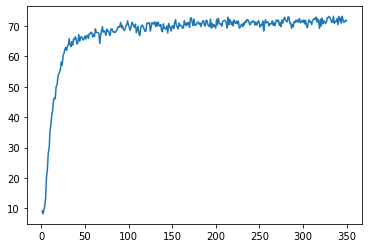

In [8]:
print("Total Run {} epoch(s)".format(Grandstore['total_epoch_run']))

plt.plot(*[range(1,Grandstore['total_epoch_run']+1)],Grandstore['acclog'])
print("Accuracy MIN: {} / MAX: {}".format(Grandstore['minacc'],Grandstore['maxacc']))
print()
print("Top {} performing epochs:".format(TOP_ACCURACY_TRACK))


gstm=Grandstore['topmodels']
for i in range(TOP_ACCURACY_TRACK):
    easy=gstm[TOP_ACCURACY_TRACK-i-1]
    print("#{} epoch {}\t||train_acc {:.2f}%\t||test {:.2f}%".format(i+1,easy[2],easy[0],easy[1]))
print()
print("Last epoch:")
lsmd=Grandstore['lastmodel']
print("epoch {}\t||train_acc {:.2f}%\t||test {:.2f}%".format(Grandstore['total_epoch_run'],lsmd[0],lsmd[1]))
      
print()
print("The model has parameters: {}".format(get_n_params(model)))
#grandstore['lastmodel']=((training_accuracy,train_epoch,thisepochtestresult))
# grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)

In [9]:
  
f1=open(grandstore_string,"wb")
pickle.dump(Grandstore,f1)
f1.close()

print("writings done!")
print("Files at: "+grandstore_string)

# with open(grandstore_string, 'rb') as file:
#     myvar = pickle.load(file)
#     print(myvar)

writings done!
Files at: grandstore/caltech101_EfficientNetb4_stn120220102014549.pkl
